In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import itertools

from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, LSTM
from sklearn.metrics import confusion_matrix

In [2]:
df_crop = pd.read_csv('../input/crop-recommendation-dataset/Crop_recommendation.csv')
df_crop.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [3]:
df_crop.isna().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [4]:
df_crop['label'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [5]:
df_crop.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [6]:
df_crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [7]:
df_crop['label'].value_counts()

rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: label, dtype: int64

In [8]:
label_encode = LabelEncoder()

df_crop['label'] = label_encode.fit_transform(df_crop['label'])
crop_category = {index : label for index, label in enumerate(label_encode.classes_)}
crop_category

{0: 'apple',
 1: 'banana',
 2: 'blackgram',
 3: 'chickpea',
 4: 'coconut',
 5: 'coffee',
 6: 'cotton',
 7: 'grapes',
 8: 'jute',
 9: 'kidneybeans',
 10: 'lentil',
 11: 'maize',
 12: 'mango',
 13: 'mothbeans',
 14: 'mungbean',
 15: 'muskmelon',
 16: 'orange',
 17: 'papaya',
 18: 'pigeonpeas',
 19: 'pomegranate',
 20: 'rice',
 21: 'watermelon'}

In [9]:
df_crop

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,20
1,85,58,41,21.770462,80.319644,7.038096,226.655537,20
2,60,55,44,23.004459,82.320763,7.840207,263.964248,20
3,74,35,40,26.491096,80.158363,6.980401,242.864034,20
4,78,42,42,20.130175,81.604873,7.628473,262.717340,20
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,5
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,5
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,5
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,5


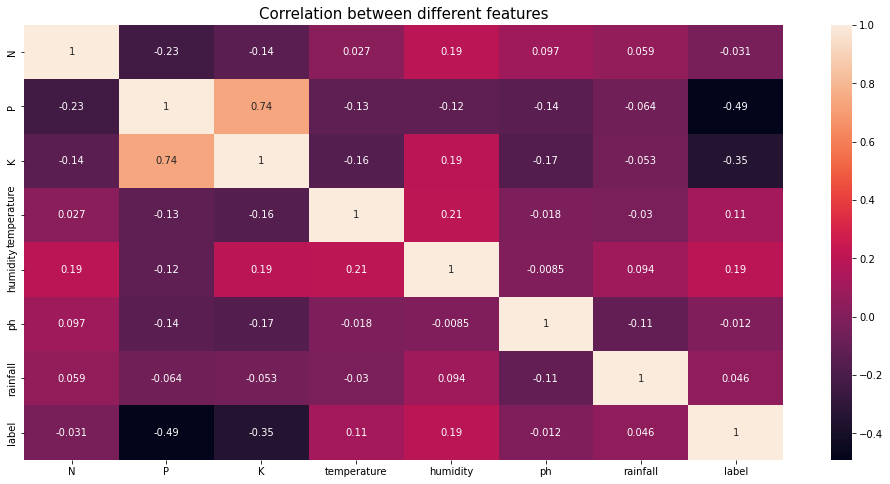

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(17, 8))
sns.heatmap(df_crop.corr(), annot=True )
plt.title('Correlation between different features', fontsize = 15, c='black')
plt.show()

In [11]:
X = df_crop.drop('label', axis = 1)
y = df_crop['label']

In [12]:
X

,N,P,K,temperature,humidity,ph,rainfall
0,90,42,43,20.879744,82.002744,6.502985,202.935536
1,85,58,41,21.770462,80.319644,7.038096,226.655537
2,60,55,44,23.004459,82.320763,7.840207,263.964248
3,74,35,40,26.491096,80.158363,6.980401,242.864034
4,78,42,42,20.130175,81.604873,7.628473,262.717340
...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507
2196,99,15,27,27.417112,56.636362,6.086922,127.924610
2197,118,33,30,24.131797,67.225123,6.362608,173.322839
2198,117,32,34,26.272418,52.127394,6.758793,127.175293


In [13]:
X = X.to_numpy()
X = X.reshape(X.shape[0], X.shape[1], 1)

In [14]:
X.shape

(2200, 7, 1)

In [15]:
y = y.to_numpy()
y = y.reshape(y.shape[0], 1)

In [16]:
y.shape

(2200, 1)

In [17]:
print('Loading data...')
X_train, X_test, y_train, y_test = tts(X, y, train_size = 0.8)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

Loading data...
1760 train sequences
440 test sequences


In [18]:
X_train.shape

(1760, 7, 1)

In [19]:
y_train.shape

(1760, 1)

In [20]:
model = Sequential()
model.add(Input(shape=(7,1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', strides=1, name="Conv1D_1"))
model.add(Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv1D_2"))
model.add(Conv1D(filters=16, kernel_size=2, activation='relu', name="Conv1D_3"))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D"))
model.add(LSTM(50))
model.add(Flatten())
model.add(Dense(22, activation = 'softmax',  name="Dense_2"))

2022-11-04 17:22:42.373736: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 5, 64)             256       
_________________________________________________________________
dropout (Dropout)            (None, 5, 64)             0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 3, 32)             6176      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 2, 16)             1040      
_________________________________________________________________
MaxPooling1D (MaxPooling1D)  (None, 1, 16)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                13400     
_________________________________________________________________
flatten (Flatten)            (None, 50)                0

In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/best_model.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

In [23]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = 'accuracy'
)

In [24]:
batch_size = 64
epochs = 100

history = model.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    batch_size = batch_size,
    epochs = epochs,
    callbacks=checkpoint)

2022-11-04 17:22:43.024754: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
22/22 [==============================] - 3s 40ms/step - loss: 3.0865 - accuracy: 0.0604 - val_loss: 2.9521 - val_accuracy: 0.1449
Epoch 2/100
22/22 [==============================] - 0s 10ms/step - loss: 2.9587 - accuracy: 0.1115 - val_loss: 2.8305 - val_accuracy: 0.1818
Epoch 3/100
22/22 [==============================] - 0s 9ms/step - loss: 2.7985 - accuracy: 0.1420 - val_loss: 2.6424 - val_accuracy: 0.2926
Epoch 4/100
22/22 [==============================] - 0s 11ms/step - loss: 2.5858 - accuracy: 0.2457 - val_loss: 2.4000 - val_accuracy: 0.3381
Epoch 5/100
22/22 [==============================] - 0s 10ms/step - loss: 2.3498 - accuracy: 0.3409 - val_loss: 2.1162 - val_accuracy: 0.4205
Epoch 6/100
22/22 [==============================] - 0s 10ms/step - loss: 2.1021 - accuracy: 0.4226 - val_loss: 1.8610 - val_accuracy: 0.4602
Epoch 7/100
22/22 [==============================] - 0s 10ms/step - loss: 1.8460 - accuracy: 0.5021 - val_loss: 1.6230 - val_accuracy: 0.5625
Epoch 8

In [25]:
# Conv1D: (batch, length, channels)
# LSTM: (batch, timeSteps, features)

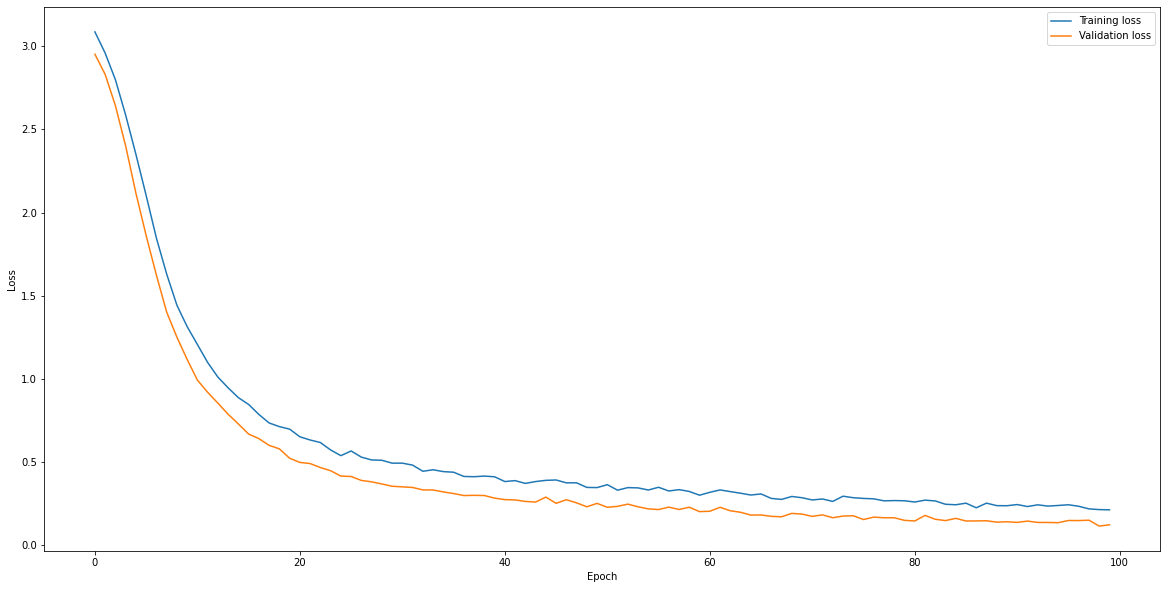

In [26]:
plt.figure(figsize = (20, 10))

plt.plot(range(epochs), history.history['loss'], label = 'Training loss')
plt.plot(range(epochs), history.history['val_loss'], label = 'Validation loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [27]:
model.evaluate(X_test, y_test)

14/14 [==============================] - 0s 3ms/step - loss: 0.1563 - accuracy: 0.9523


[0.15631859004497528, 0.9522727131843567]

In [28]:
y_pred = model.predict(X_test)

In [29]:
y_pred.shape

(440, 22)

In [30]:
from sklearn.metrics import classification_report

cols = crop_category.keys()

df_preds = pd.DataFrame(y_pred, columns=cols)

df_preds.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.000006,0.000159,0.002885,4.476824e-04,0.000561,0.000329,0.000017,0.000025,0.000565,0.001196,...,0.000620,0.131227,0.000055,0.000037,0.000127,0.001772,0.858933,0.000032,0.000064,0.000002
1,0.000014,0.000007,0.000301,1.001361e-04,0.000004,0.000003,0.000308,0.000005,0.000006,0.000030,...,0.000059,0.004351,0.986965,0.000386,0.000977,0.000348,0.000045,0.000067,0.000013,0.000053
2,0.000008,0.000012,0.000075,5.746012e-07,0.000010,0.000027,0.001212,0.000002,0.000017,0.000007,...,0.000363,0.000747,0.000130,0.981065,0.000070,0.000288,0.000025,0.000643,0.000019,0.014964
3,0.000009,0.000096,0.000079,3.033349e-04,0.000024,0.000514,0.000098,0.000032,0.000181,0.952920,...,0.000038,0.000307,0.000006,0.000019,0.000042,0.000029,0.044894,0.000006,0.000189,0.000007
4,0.000017,0.000005,0.000041,1.205813e-04,0.000102,0.000068,0.000001,0.000008,0.000021,0.000007,...,0.994510,0.003135,0.000006,0.000064,0.000025,0.001712,0.000122,0.000018,0.000002,0.000007


In [31]:
df_preds.shape

(440, 22)

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Dark2):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    # set the size of the figure here
    plt.figure(figsize=(15,10))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=80) # set x-axis text angle here
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [33]:
b =  y_pred.argmax(axis=1)
cm = confusion_matrix(y_test, b)

Confusion matrix, without normalization
[[13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 16  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 16  0  0  1  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0  0 25  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 22  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  

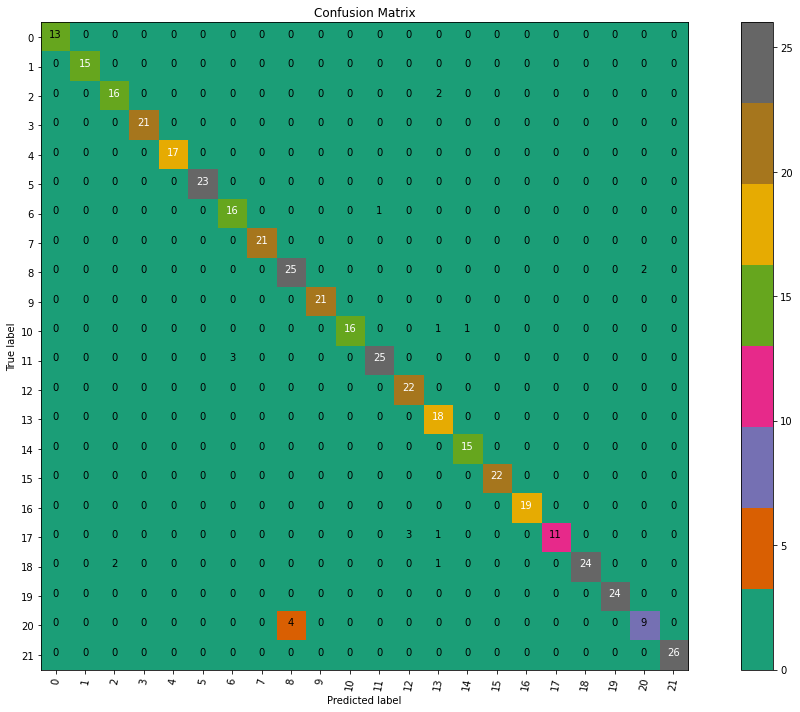

In [34]:
cm_plot_labels = cols

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [35]:
from sklearn.metrics import r2_score
r2_score(y_test, b, multioutput='variance_weighted')

0.8889676801417808